# Introduction

This tutorial aims to build step-by-step a Gradient descent algorithm, a Support Vector Machine (SVM) classifier and a K-nearest neighbour (KNN) classifiers.
One of the motivation behind its development is the gap in the tutorial space between the very high level implementations (for example on widespread machine-learning packages such as Scikit-learn and Tensorflow)and the very low one, for example for people that develop such methods (in this case advanced knowledge of computer science and mathematics (optimization) are required). 
What is commonly missing is an introduction to the principles of the machine-learning algorithms for people who want to deep into the method without necessarily possessing a degree in mathematics, and therefore, this project addresses exactly this target of people.
To understand the content, it is necessary to have basic knowledges of linear algebra (mostly dot product and matrix multiplication), its implementation in Numpy and a few commonly used packages (Pandas, Matplotlib).

Importantly, this is not a complete overview of the machine learning methods (here the unsupervised methods are not even mentiones) but rather, my personal learning journey on a few key machine learning topics. 

# Gradient Descent

Despite the fact that machine learning is a very diverse field, including methods ranging from simple linear regression to deep learning, Gradient Descent is likely the main method to find (a.k.a. 'optimize', using terms more common in machine learning field) the models' parameters (a.k.a. weights). The first question I asked myself at the time I started working with machine learning is simply: why is it the most commonly chosen method? The answer is not clear at first when fitting a simple linear model that can be solved using very simple linear algebra equations. I becomes clear when complex models with houndreds or even thousands of parameters are fit. In such cases, approaching the question using algebra will be extremely demanding in terms of computation or even make the optimization of the weights impossible. In such cases optimization methods (numeric) are the default choice.
Here I will start from the simplest example explaining the principle and gradually extend it to a more general case with application to solve a very simple linear model.

The key to understand the gradient descent is to understand that the weights are adjusted every iteration using the derivate of the gradient. The main idea is that subtracting the derivate to the weights allow the fit to approach the minima in the next iteration. The cost function that I chose to use here is the simplest one: the sum of squares. The derivate of the sum of squares is a bell curve ('U' shaped curve) defined as: 

Sum of squeres cost function derivate over weights: $\frac{\delta Cost}{\delta Weight} = (prediction - y) * x$

In [3]:
# imports and plot customizations
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

matplotlib.rcParams['xtick.color'] = 'grey'
matplotlib.rcParams['ytick.color'] = 'grey'
matplotlib.rcParams['xtick.major.size'] = 7
matplotlib.rcParams['ytick.major.size'] = 7
# matplotlib.rcParams['xtick.labelsize'] = 10
# matplotlib.rcParams['ytick.labelsize'] = 10
matplotlib.rcParams['font.size'] = 11
matplotlib.rcParams['xtick.major.pad'] = 8
matplotlib.rcParams['ytick.major.pad'] = 8
matplotlib.rcParams['legend.frameon'] = False
matplotlib.rcParams['axes.edgecolor'] = 'grey'
matplotlib.rcParams['text.color'] = 'grey'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['ytick.minor.visible'] = True
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['legend.loc'] = 'upper left'
matplotlib.rcParams['figure.constrained_layout.h_pad'] = 0.12
matplotlib.rcParams['figure.constrained_layout.w_pad'] = 0.12

# Single parameter gradient descent

In [26]:
def gradient_descent(goal_pred, input_, epoch) :
    weight = 0.0
    weight_list = []
    pred_list = []
    delta_list = []
    weight_delta_list = []
    weight_list = []
    error_list = []
    epoch_list = list(range(int(epoch)))
    for i in range(int(epoch)):
        weight_list.append(weight)
        pred = input_ * weight
        pred_list.append(pred)

        print(f'weight: {weight}, Prediction: {pred}')
        error = (pred - goal_pred) ** 2
        error_list.append(error)
        delta = pred - goal_pred
        delta_list.append(delta)

        weight_delta = delta * input_
        weight_delta_list.append(weight_delta)
        weight = weight - weight_delta
        print(f'delta: {delta}, weight_delta: {weight_delta}, weight: {weight}\nError: {error}\n')
    
    output = {'weight':weight_list, 'pred':pred_list, 'error':error_list, 
            'delta':delta_list, 'weight_delta':weight_delta_list, 'epoch':epoch_list}
    
    fig, ax = plt.subplots(2,2, constrained_layout=True, figsize = (8,8))
    ax[0,0].plot(output['epoch'], output['error'], c = 'grey', linewidth = 3)
    ax[0,1].scatter(output['weight'], output['error'], c = output['epoch'])
    ax[1,0].plot(output['epoch'], output['pred'], c = 'grey', linewidth = 3)
    ax[1,1].plot(output['epoch'], output['weight'], c = 'tab:green', linewidth = 3)
    for axes, xlab, ylab in zip(ax.ravel().tolist(), ['epoch']+['weight']+['epoch']*2, ['Error']*2+['pred', 'weight']):
        axes.set(xlabel = xlab, ylabel = ylab)
        
    return output

Converging example:

weight: 0.0, Prediction: 0.0
delta: -2.0, weight_delta: -1.0, weight: 1.0
Error: 4.0

weight: 1.0, Prediction: 0.5
delta: -1.5, weight_delta: -0.75, weight: 1.75
Error: 2.25

weight: 1.75, Prediction: 0.875
delta: -1.125, weight_delta: -0.5625, weight: 2.3125
Error: 1.265625

weight: 2.3125, Prediction: 1.15625
delta: -0.84375, weight_delta: -0.421875, weight: 2.734375
Error: 0.7119140625

weight: 2.734375, Prediction: 1.3671875
delta: -0.6328125, weight_delta: -0.31640625, weight: 3.05078125
Error: 0.40045166015625

weight: 3.05078125, Prediction: 1.525390625
delta: -0.474609375, weight_delta: -0.2373046875, weight: 3.2880859375
Error: 0.22525405883789062

weight: 3.2880859375, Prediction: 1.64404296875
delta: -0.35595703125, weight_delta: -0.177978515625, weight: 3.466064453125
Error: 0.12670540809631348

weight: 3.466064453125, Prediction: 1.7330322265625
delta: -0.2669677734375, weight_delta: -0.13348388671875, weight: 3.59954833984375
Error: 0.07127179205417633

weight: 3.59954833

{'weight': [0.0,
  1.0,
  1.75,
  2.3125,
  2.734375,
  3.05078125,
  3.2880859375,
  3.466064453125,
  3.59954833984375,
  3.6996612548828125,
  3.7747459411621094,
  3.831059455871582,
  3.8732945919036865,
  3.904970943927765,
  3.9287282079458237,
  3.9465461559593678,
  3.959909616969526,
  3.9699322127271444,
  3.9774491595453583,
  3.9830868696590187],
 'pred': [0.0,
  0.5,
  0.875,
  1.15625,
  1.3671875,
  1.525390625,
  1.64404296875,
  1.7330322265625,
  1.799774169921875,
  1.8498306274414062,
  1.8873729705810547,
  1.915529727935791,
  1.9366472959518433,
  1.9524854719638824,
  1.9643641039729118,
  1.9732730779796839,
  1.979954808484763,
  1.9849661063635722,
  1.9887245797726791,
  1.9915434348295094],
 'error': [4.0,
  2.25,
  1.265625,
  0.7119140625,
  0.40045166015625,
  0.22525405883789062,
  0.12670540809631348,
  0.07127179205417633,
  0.040090383030474186,
  0.02255084045464173,
  0.012684847755735973,
  0.007135226862601485,
  0.004013565110213335,
  0.002257

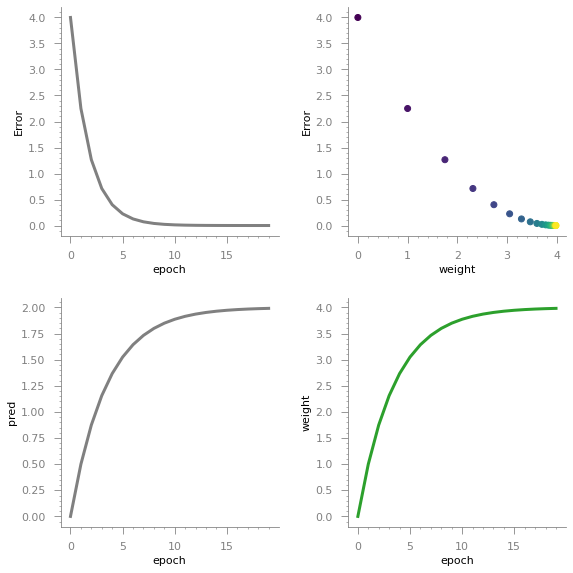

In [27]:
gradient_descent(goal_pred = 2, input_ = .5, epoch = 20) # converging from one side (steps are small)

Converging example with ping-pong from either sides of the curve:

weight: 0.0, Prediction: 0.0
delta: -2.0, weight_delta: -2.8, weight: 2.8
Error: 4.0

weight: 2.8, Prediction: 3.9199999999999995
delta: 1.9199999999999995, weight_delta: 2.6879999999999993, weight: 0.11200000000000054
Error: 3.686399999999998

weight: 0.11200000000000054, Prediction: 0.15680000000000074
delta: -1.8431999999999993, weight_delta: -2.5804799999999988, weight: 2.6924799999999993
Error: 3.3973862399999972

weight: 2.6924799999999993, Prediction: 3.7694719999999986
delta: 1.7694719999999986, weight_delta: 2.477260799999998, weight: 0.21521920000000128
Error: 3.131031158783995

weight: 0.21521920000000128, Prediction: 0.3013068800000018
delta: -1.6986931199999982, weight_delta: -2.3781703679999975, weight: 2.5933895679999988
Error: 2.885558315935328

weight: 2.5933895679999988, Prediction: 3.630745395199998
delta: 1.6307453951999982, weight_delta: 2.283043553279997, weight: 0.3103460147200017
Error: 2.659330543965998

weight: 0.3103460147200017, Prediction: 0.434484420608002

{'weight': [0.0,
  2.8,
  0.11200000000000054,
  2.6924799999999993,
  0.21521920000000128,
  2.5933895679999988,
  0.3103460147200017,
  2.5020678258687985,
  0.3980148871659539,
  2.417905708320684,
  0.47881052001214375,
  2.3403419007883417,
  0.5532717752431926,
  2.268859095766535,
  0.6218952680641268,
  2.2029805426584383,
  0.6851386790478995,
  2.1422668681140165,
  0.7434238066105447,
  2.086313145653877,
  0.7971393801722786,
  2.0347461950346126,
  0.846643652766772,
  1.9872220933438989,
  0.8922667903898571,
  1.9434238812257372,
  0.9343130740232923,
  1.9030594489376396,
  0.9730629290198664,
  1.8658595881409283,
  1.008774795384709,
  1.8315761964306794,
  1.0416868514265483,
  1.7999806226305137,
  1.0720186022747071,
  1.770862141816281,
  1.0999723438563704,
  1.7440265498978844,
  1.1257345120980315,
  1.71929486838589,
  1.1494769263495457,
  1.6965021507044362,
  1.1713579353237418,
  1.6754963820892081,
  1.1915234731943605,
  1.656137465733414,
  1.2101080328

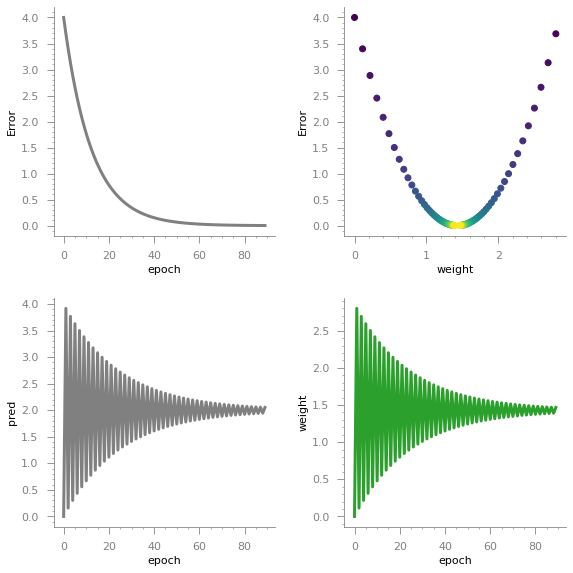

In [47]:
gradient_descent(goal_pred = 2, input_ = 1.4, epoch = 90) # converging but ping pong from one side to the other, steps are quite big

Diverging example:

weight: 0.0, Prediction: 0.0
delta: -2.0, weight_delta: -3.6, weight: 3.6
Error: 4.0

weight: 3.6, Prediction: 6.48
delta: 4.48, weight_delta: 8.064000000000002, weight: -4.464000000000002
Error: 20.070400000000003

weight: -4.464000000000002, Prediction: -8.035200000000005
delta: -10.035200000000005, weight_delta: -18.06336000000001, weight: 13.599360000000008
Error: 100.7052390400001

weight: 13.599360000000008, Prediction: 24.478848000000013
delta: 22.478848000000013, weight_delta: 40.461926400000024, weight: -26.862566400000016
Error: 505.2986074071046

weight: -26.862566400000016, Prediction: -48.35261952000003
delta: -50.35261952000003, weight_delta: -90.63471513600007, weight: 63.77214873600005
Error: 2535.386292525888

weight: 63.77214873600005, Prediction: 114.78986772480009
delta: 112.78986772480009, weight_delta: 203.02176190464016, weight: -139.2496131686401
Error: 12721.554261377902

weight: -139.2496131686401, Prediction: -250.6493037035522
delta: -252.6493037035522, weig

{'weight': [0.0,
  3.6,
  -4.464000000000002,
  13.599360000000008,
  -26.862566400000016,
  63.77214873600005,
  -139.2496131686401,
  315.51913349775384,
  -703.1628590349687,
  1578.6848042383303],
 'pred': [0.0,
  6.48,
  -8.035200000000005,
  24.478848000000013,
  -48.35261952000003,
  114.78986772480009,
  -250.6493037035522,
  567.934440295957,
  -1265.6931462629439,
  2841.6326476289946],
 'error': [4.0,
  20.070400000000003,
  100.7052390400001,
  505.2986074071046,
  2535.386292525888,
  12721.554261377902,
  63831.67066188975,
  320281.7907130981,
  1607045.9130820415,
  8063513.573480454],
 'delta': [-2.0,
  4.48,
  -10.035200000000005,
  22.478848000000013,
  -50.35261952000003,
  112.78986772480009,
  -252.6493037035522,
  565.934440295957,
  -1267.6931462629439,
  2839.6326476289946],
 'weight_delta': [-3.6,
  8.064000000000002,
  -18.06336000000001,
  40.461926400000024,
  -90.63471513600007,
  203.02176190464016,
  -454.76874666639395,
  1018.6819925327226,
  -2281.847

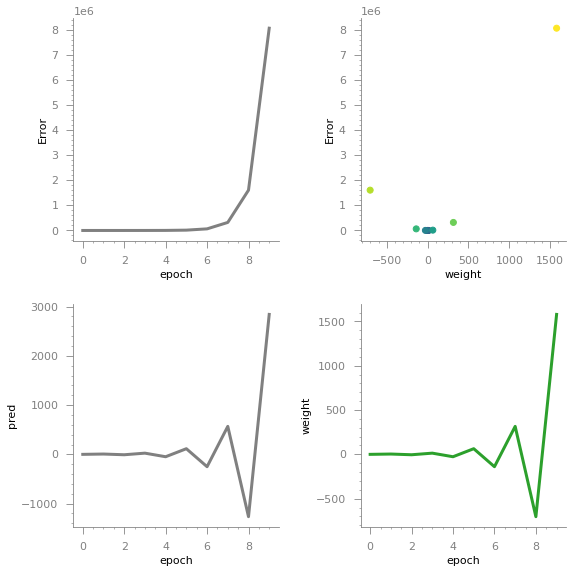

In [29]:
gradient_descent(goal_pred = 2, input_ = 1.8, epoch = 10) # diverging, steps are too big

From these examples we can see that whenever the input is large enough (last example) the derivate becomes also large and as a consequence the weights become large. This implies that instead of approaching the minima, we make a much larger step and go all the way to the other side of the curve exceeding the point where the cost function would be lower than the previous iteration. The example in the middle explains the milder version of this problem, the case in which the wheights are large enough to go all the way to the other side of the curve but not large enough to pass the point in which the cost funcion increases again.

This is one of the most important concepts in any optimization method: the input values can cause divergence if large enough. To compensate for this, it is a common practice to introduce the alpha (scalar) parameter with the purpose of adjusting the step size in case the derivate becomes too large.

# Multiple parameters gradient descent

In [12]:
def gradient_descent_vector(goal_pred, input_, weights, alpha = 1, epoch = 10):
    input_ = np.float64(input_)
    weights = np.float64(weights)
    weights_list = np.zeros((epoch, len(input_)))
    pred_list = np.zeros(epoch)
    delta_list = np.zeros(epoch)
    weights_deltas_list = np.zeros((epoch, len(input_)))
    error_list = np.zeros(epoch)
    epoch_list = np.arange(epoch)
    
    for i in epoch_list:
        pred_list[i] = np.dot(input_, weights)
        delta_list[i] = pred_list[i] - goal_pred
        error_list[i] = delta_list[i] ** 2
        weights_deltas_list[i, :] = delta_list[i] * input_
        print(weights, weights_deltas_list[i, :], alpha * weights_deltas_list[i, :])
        weights -= alpha * weights_deltas_list[i, :]
        weights_list[i, :] = weights
    output = {'weight':weights_list, 'pred':pred_list, 'error':error_list, 
            'delta':delta_list, 'weight_delta':weights_deltas_list, 'epoch':epoch_list}
    
    fig, ax = plt.subplots(1,3, constrained_layout=True, figsize = (12,4))
    ax[0].scatter(output['weight'][:, 0], output['error'], c = output['epoch'])
    ax[1].scatter(output['weight'][:, 1], output['error'], c = output['epoch'])
    ax[2].scatter(output['weight'][:, 2], output['error'], c = output['epoch'])
    for axes, xlab, ylab in zip(ax.ravel().tolist(), ['weight 0', 'weight 1', 'weight 2'], ['error'] *3):
        axes.set(xlabel = xlab, ylabel = ylab)
    return output

[ 0.   0.2 -0.1] [-8.415  -0.6435 -1.188 ] [-0.08415  -0.006435 -0.01188 ]
[ 0.08415   0.206435 -0.08812 ] [-2.17843313 -0.16658606 -0.3075435 ] [-0.02178433 -0.00166586 -0.00307544]
[ 0.10593433  0.20810086 -0.08504457] [-0.56394188 -0.04312497 -0.07961532] [-0.00563942 -0.00043125 -0.00079615]
[ 0.11157375  0.20853211 -0.08424841] [-0.14599045 -0.01116398 -0.02061042] [-0.0014599  -0.00011164 -0.0002061 ]
[ 0.11303365  0.20864375 -0.08404231] [-0.03779328 -0.00289007 -0.00533552] [-3.77932785e-04 -2.89007424e-05 -5.33552167e-05]
[ 0.11341159  0.20867265 -0.08398895] [-0.00978373 -0.00074817 -0.00138123] [-9.78373497e-05 -7.48167969e-06 -1.38123317e-05]
[ 0.11350942  0.20868013 -0.08397514] [-0.00253276 -0.00019368 -0.00035757] [-2.53276439e-05 -1.93681983e-06 -3.57566738e-06]
[ 0.11353475  0.20868207 -0.08397156] [-6.55669382e-04 -5.01394233e-05 -9.25650892e-05] [-6.55669382e-06 -5.01394233e-07 -9.25650892e-07]
[ 0.11354131  0.20868257 -0.08397064] [-1.69736411e-04 -1.29798432e-05 -2

{'weight': array([[ 0.08415   ,  0.206435  , -0.08812   ],
        [ 0.10593433,  0.20810086, -0.08504457],
        [ 0.11157375,  0.20853211, -0.08424841],
        [ 0.11303365,  0.20864375, -0.08404231],
        [ 0.11341159,  0.20867265, -0.08398895],
        [ 0.11350942,  0.20868013, -0.08397514],
        [ 0.11353475,  0.20868207, -0.08397156],
        [ 0.11354131,  0.20868257, -0.08397064],
        [ 0.11354301,  0.2086827 , -0.0839704 ],
        [ 0.11354345,  0.20868273, -0.08397034]]),
 'pred': array([0.01      , 0.74371375, 0.9336539 , 0.98282465, 0.99555373,
        0.99884897, 0.99970203, 0.99992286, 0.99998003, 0.99999483]),
 'error': array([9.80100000e-01, 6.56826419e-02, 4.40180538e-03, 2.94992559e-04,
        1.97692997e-05, 1.32486464e-06, 8.87874804e-08, 5.95020537e-09,
        3.98760544e-10, 2.67234425e-11]),
 'delta': array([-9.90000000e-01, -2.56286250e-01, -6.63461030e-02, -1.71753474e-02,
        -4.44626806e-03, -1.15102764e-03, -2.97972281e-04, -7.71375743e-

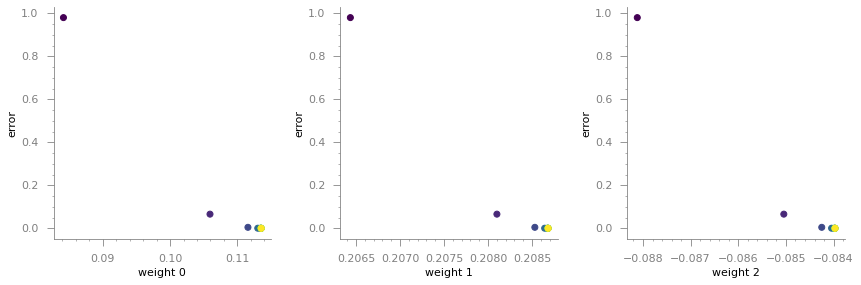

In [13]:
gradient_descent_vector(goal_pred = 1, input_ = [8.5, 0.65, 1.2], weights = [0, 0.2, -.1], alpha = 1e-2)

The method is exactly the same as for a single scalar input, the only difference is that when the derivate is computed, instead of obtaining a scalar value, the weight vector is multiplied by delta thereby returning a new vector.

# Multiple parameters, multiple samples (linear model) gradient descent

In [71]:
def gradient_descent_matrix(X, y, weights = None, alpha = 1, epoch = 100):
    n_samples = X.shape[0]
    n_params = X.shape[1]
    
    if weights == None:
        weights = np.zeros(n_params) 
    else:
        weights = np.float64(weights)
        
    if len(weights) != n_params:
        raise Exception(f'Weights must have the same length as the columns in X')
        
    weights_list = np.zeros((epoch, n_params))
    pred_list = np.zeros((epoch, n_samples))
    delta_list = np.zeros((epoch, n_samples))
    weights_deltas_list = np.zeros((epoch, n_params))
    error_list = np.zeros(epoch)
    epoch_list = np.arange(epoch)
    
    for i in epoch_list:
        pred_list[i] = np.dot(X, weights)
        delta_list[i] = pred_list[i] - y
        error_list[i] = np.linalg.norm(delta_list[i])**2 / (n_samples - n_params - 1) # Residual Variance
        weights_deltas_list[i, :] = np.dot(X.T, delta_list[i]) / (n_samples - n_params - 1)
        weights -= alpha * weights_deltas_list[i, :]
        weights_list[i, :] = weights

    output = {'weight':weights_list, 'pred':pred_list, 'error':error_list, 
            'delta':delta_list, 'weight_delta':weights_deltas_list, 'epoch':epoch_list}
    
    ols_coef = np.matmul(np.linalg.inv(np.matmul(X.T, X)), np.dot(X.T, y)) # (X.T X)^-1 X.T y = (X.T X)^-1 (X.T X) beta
    print(f'OLS weights estimate: {ols_coef}')
    print(f'Final weights estimate: {weights}')

    _, ax = plt.subplots(2,2, constrained_layout=True, figsize = (8,8))
    ax[0,0].plot(output['epoch'], output['error'], color = 'grey', linewidth = 3)
    ax[0,1].scatter(X[:, 1], y, c = 'grey')
    ax[0,1].plot(X[:, 1], np.dot(X, ols_coef), c = 'tab:orange', label = 'OLS')
    ax[0,1].plot(X[:, 1], np.dot(X, output['weight'][-1]), c = 'tab:green', label = 'Grad.\nDescent')
    ax[0,1].legend()
    ax[1,0].plot(output['epoch'], output['weight'][:, 0], color = 'tab:green', linewidth = 3)
    ax[1,1].plot(output['epoch'], output['weight'][:, 1], color = 'tab:green', linewidth = 3)
    for axes, xlab, ylab in zip(ax.ravel()[[1,0,2,3]].tolist(), ['x'] + ['epoch'] *3, ['y', 'Error', 'weight 0', 'weight 1']):
            axes.set(xlabel = xlab, ylabel = ylab)
    
    return output

In [74]:
coef = [4, 3]
X = np.power.outer(np.random.rand(100), [0, 1]) # [0 = intercept col, 1 = x]
y = np.dot(X, coef) + np.random.rand(100)

OLS weights estimate: [4.47865232 3.07097196]
Final weights estimate: [4.66317003 2.66952687]


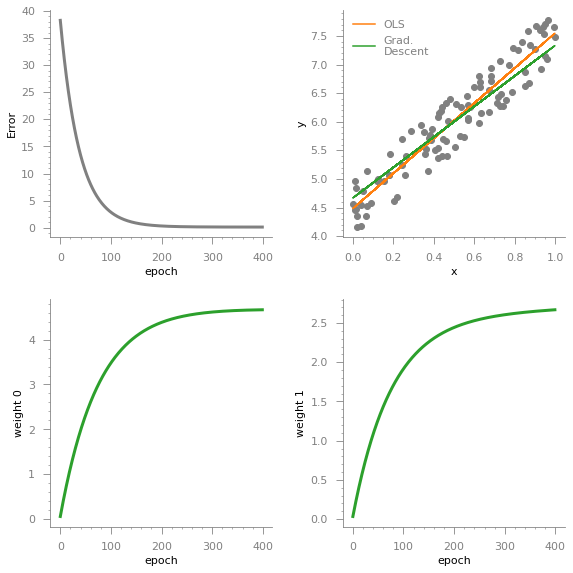

In [75]:
coef_estimate = gradient_descent_matrix(X, y, weights = [0, 0], alpha = 1e-2, epoch = 400)

In this case, with the chosen 'alpha' the gradient descent optimizes te weights after just ~200 iterations. 

Changing 'alpha' changes the step size and therefore how quickly the minima in the cost function is achieved.

OLS weights estimate: [4.47865232 3.07097196]
Final weights estimate: [4.37507057 2.43982875]


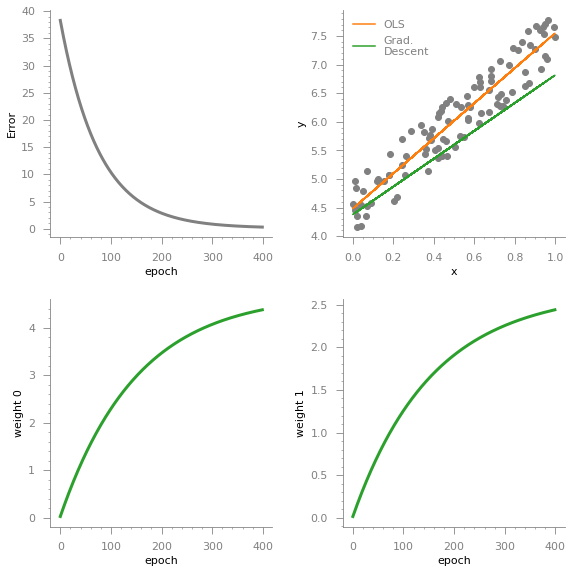

In [94]:
coef_estimate = gradient_descent_matrix(X, y, weights = [0, 0], alpha = 0.5*1e-2, epoch = 400)

The example above enphasizes how important it is to chose the correct magnitude of alpha. This has a tremendous effect not only on whether or not the optimization will converge to a minima but also on the amount of iteration it takes to get there.
Choosing the ideal 'alpha' is a dogma in most machine learning method and a common point of optimization. 

OLS weights estimate: [4.47865232 3.07097196]
Final weights estimate: [4.49561945 3.03943788]


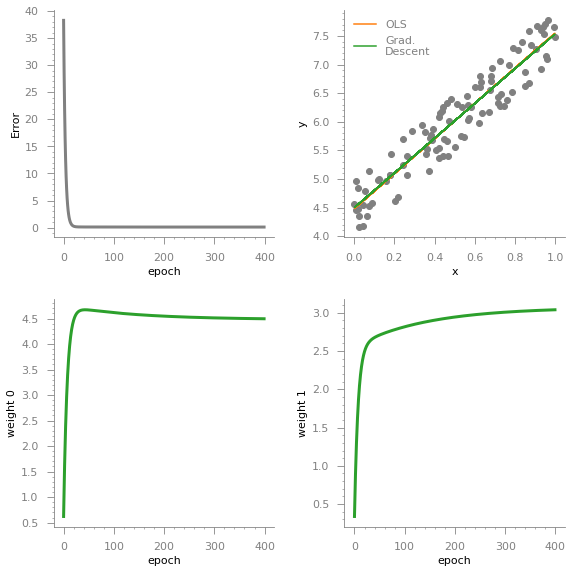

In [152]:
coef_estimate = gradient_descent_matrix(X, y, weights = [0, 0], alpha = 1e-1, epoch = 400)

This last example enphasizes another very important concept in gradient descent: looking at the weight for the intercept(weight 0), it is possible to sse an increment followed by a decrement.

This has to do with the fact that the optimization doesn't work linearly. In this case the 'U' shaped bell curved is spanning 2 dimensions (2 weights), the optimization follows the path that provides the LOCAL steepest decrement. In the case above, until iteration ~30, the algorithm found one locally steeper direction; this trajectory changed at around 30 iterations, at that stage, decreasing the intercept weight and increasing the weight on x provided steeper decrements in the cost function.  

[Text(0.5, 0, 'weight 1'), Text(0, 0.5, 'Mean sq.')]

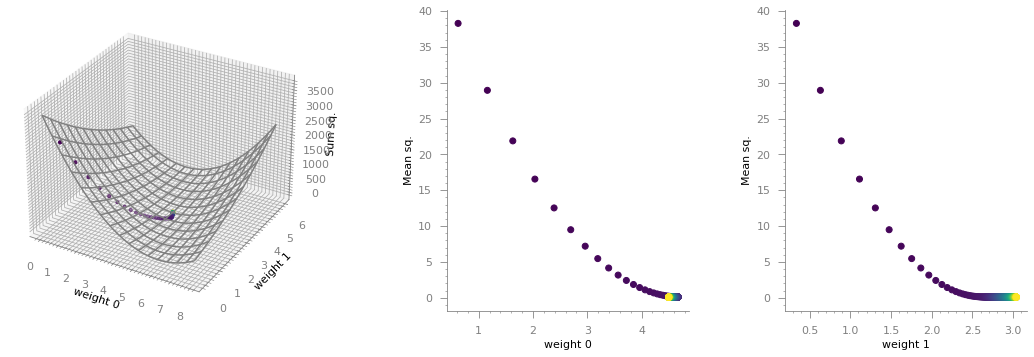

In [191]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib

def sum_of_squares(w0, w1):
    pred = np.dot(X, [w0, w1])
    delta = pred - y
    sum_of_squares = np.linalg.norm(delta)**2
    return sum_of_squares

grid = np.mgrid[0:8:0.1, 0:6:0.1]
sum_squares = np.vectorize(sum_of_squares)(*grid)
sum_squares_optimization = np.vectorize(sum_of_squares)(*coef_estimate['weight'].T)

fig = plt.figure(constrained_layout=True, figsize = (15, 5))
gc1 = fig.add_gridspec(nrows = 1, ncols = 3, width_ratios=[5,3,3])
fig.set_constrained_layout_pads(wspace=0.1) 

ax = fig.add_subplot(gc1[0, 0], projection='3d')
#ax.plot_surface(*grid, sum_squares, rstride=1, cstride=1, cmap=matplotlib.cm.viridis.reversed(),
#                       linewidth=0, antialiased=False)
ax.plot_wireframe(*grid, sum_squares, rstride=5, cstride=5, colors = 'grey')

ax.scatter(
    *coef_estimate['weight'].T,
    zs= sum_squares_optimization,
    s = 10,
    c = coef_estimate['epoch']
)  
ax.set(xlabel = 'weight 0', ylabel = 'weight 1', zlabel = 'Sum sq.')

ax.view_init(30, 300)

ax1 = fig.add_subplot(gc1[0, 1])
ax1.scatter(coef_estimate['weight'][:, 0], coef_estimate['error'], c = coef_estimate['epoch'])
ax1.set(xlabel = 'weight 0', ylabel = 'Mean sq.')

ax2 = fig.add_subplot(gc1[0, 2])
ax2.scatter(coef_estimate['weight'][:, 1], coef_estimate['error'], c = coef_estimate['epoch'])
ax2.set(xlabel = 'weight 1', ylabel = 'Mean sq.')

The first plot shows that the trajectory is not straight. 

Just for clarity, in the 2nd and 3rd plots, the error is not the sum of squares but the mean squares (sum of squares divided by the degrees of freedom). This was done just out of practicality since the gradient descent object already had this information.

# SVM

Regarding the SVM section, to understand how the gradient descent works it is best to take a look to the "Perceptron" algorithm since this implementation is based on it. The simplest version of the agorithm does not have an optimization workflow based on gradient descent (for which the derivate of the cost function needs to be calculated). The algorithm works simply by exploiting a simple property of the dot-product: if the classification is incorrect, the vector dotted with the weights is added or subtracted to the weights. On the other hand, the fact that the vector is added (or subtracted) to the weights resembles the concept used in the gradient descent described above. A good description of the theory of this method can be found at this link:  https://page.mi.fu-berlin.de/rojas/neural/chapter/K4.pdf.
The packages available in the repositories identify the support vectors in different ways (for example by solving a Lagrange multiplier equation) which are on the one hand more efficient, but, on the other hand less accessible. 

The SVM method works by identifying a vector whose dotproduct defines a hyperplane separating 2 categories. If the dataset contains more than 2 categories, a model for each combination needs to be fitted.
In the example below we select a portion of the Iris dataset containing 2 of the 3 species.

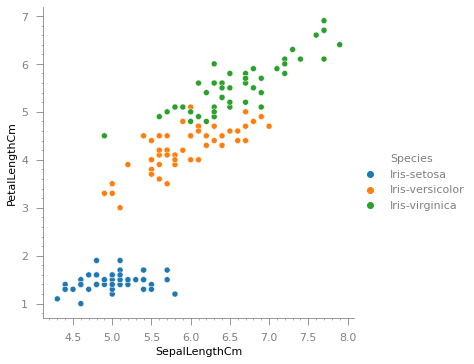

In [37]:
# Load the Iris dataset
iris = pd.read_csv(
    'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data',
    names = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm', 'Species']
    )

sns.relplot(data = iris, x = 'SepalLengthCm',  y = 'PetalLengthCm', hue = 'Species')

# Alternatively, the Iris dataset can be loaded from the scikit-learn package (see the Apendix for more information).

In [38]:
# Select 2 categories that do not overlap
iris_model = iris.query('Species == "Iris-setosa" | Species == "Iris-versicolor"')
# Replace the names of the 2 with '-1' and '1' (irrelevant for the Perceptron part but necessary for the SVM)
iris_model = iris_model.replace({'Species':{'Iris-setosa':1, 'Iris-versicolor':-1}})

X = iris_model.loc[:, ['SepalLengthCm',  'PetalLengthCm']].values
y = iris_model.loc[:, 'Species'].values

for d in ('iris', 'X', 'y'):
    print(f'{d}:\n{eval(d + "[0:-1:10]")}')

iris:
     SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm          Species
0              5.1           3.5            1.4           0.2      Iris-setosa
10             5.4           3.7            1.5           0.2      Iris-setosa
20             5.4           3.4            1.7           0.2      Iris-setosa
30             4.8           3.1            1.6           0.2      Iris-setosa
40             5.0           3.5            1.3           0.3      Iris-setosa
50             7.0           3.2            4.7           1.4  Iris-versicolor
60             5.0           2.0            3.5           1.0  Iris-versicolor
70             5.9           3.2            4.8           1.8  Iris-versicolor
80             5.5           2.4            3.8           1.1  Iris-versicolor
90             5.5           2.6            4.4           1.2  Iris-versicolor
100            6.3           3.3            6.0           2.5   Iris-virginica
110            6.5           3.2            5.

# The Perceptron algorithm

In [31]:
def perceptron(X, y, epoch_size = 1e2):
    w_ = np.zeros(X.shape[1]) # start with a random 'w' vector [0,0,...,0]
    epoch_size = int(epoch_size) # epoch is the number of maximum iterations
    errors = np.zeros(epoch_size) # misclassification
    w = np.zeros((epoch_size, X.shape[1]))
    for epoch in range(1, epoch_size + 1):
        for i in range(X.shape[0]):
            y_dot = np.dot(X[i, :], w_)
            # if the dot-product correctly classifies the point we do not change 'w'
            if y_dot <= 0 and y[i] == 1: # if dot-prod negative and the class of the point is positive
                w_ = w_ + X[i, :] # NOTE: similar to the gradient descent optimization
                errors[epoch-1] += 1
            elif y_dot >= 0 and y[i] == -1: # if dot-prod positive and the class of the point is negative
                w_ = w_ - X[i, :]
                errors[epoch-1] += 1
        w[epoch-1, :] = w_
        # if the wanted result is obtained, there is no need to continue with further iterations and a break can be introduced
        # if errors[epoch-1] == 0:
        #     break
    y_predicted = np.matmul(X, w_)
    errors = errors / X.shape[0]
    w_length = np.apply_along_axis(np.linalg.norm, 1, w)
    obj = dict(w = w, errors = errors, X = X, y = y, y_predicted = y_predicted, w_length = w_length)
    return obj

In [35]:
def svm_plot(svm_obj, x_var, y_var, suptitle = ''):
    b = (svm_obj['b'] if 'b' in svm_obj else 0)
    idx_x = np.vstack((np.argmin(svm_obj['X'], axis = 0), np.argmax(svm_obj['X'], axis = 0)))[:, 0] # get the max and min to be plotted
    w = svm_obj['w'][-1]
    colors = ["tab:orange", "grey", "tab:blue"]
    breaks = [0, 0.5, 1] 
    cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap1", list(zip(breaks, colors)), N = 50) 
    colors = ['tab:blue', "tab:olive"]
    breaks = [0, 1] 
    cmap2 = matplotlib.colors.LinearSegmentedColormap.from_list("mycmap2", list(zip(breaks, colors)), N = 11)

    fig, ax = plt.subplots(2,2, constrained_layout = True, figsize = (8,8))
    fig.suptitle(suptitle)
    
    # ax[0, 0]
    pl1 = ax[0, 0].scatter(
        svm_obj['X'][:, 0], 
        svm_obj['X'][:, 1],
        c = svm_obj['y_predicted'], 
        s = np.power((svm_obj['y'] + 3), 2), # Increase the size of the points (it is based on the original class)
        cmap = cmap1
    )
    for sol, lsty in zip([0, 1, -1], ['-', ':', ':']):
        ax[0, 0].plot(
            svm_obj['X'][idx_x, 0], 
            (-w[0] * svm_obj['X'][idx_x, 0] + sol - b) / w[1], 
            c = 'grey', 
            linestyle = lsty
        )
    legend1 = ax[0, 0].legend(
        *pl1.legend_elements(prop = 'colors', num = 3, size = 10), 
        bbox_to_anchor = (1.05, 1), 
        title = 'Predicted y'
    )
    ax[0, 0].add_artist(legend1)
    ax[0, 0].legend(
        handles = pl1.legend_elements(prop = 'sizes', num = 3, color = 'grey')[0][0:3:2], 
        labels = [-1, 1], 
        bbox_to_anchor = (1.05, 0.5), title = 'y'
    )
    ax[0, 0].set(title = 'Prediction', xlabel = x_var, ylabel = y_var)
    
    # ax[0, 1]
    ax[0, 1].plot(svm_obj['errors'], c = 'grey')
    ax[0, 1].set(title = 'Error rate', xlabel = 'Epoch', ylim = [0, 1])
    
    # ax[1, 0]
    pl1 = ax[1, 0].scatter(
        *svm_obj['w'][:, [0, 1]].T.tolist(), 
        c = list(range(svm_obj['w'].shape[0])), 
        s = 20, 
        cmap = cmap2
    )
    ax[1, 0].legend(
        *pl1.legend_elements(prop = 'colors', num = 10, size = 10), 
        bbox_to_anchor = (1.05, 1),  
        title = 'Epoch'
    )
    ax[1, 0].set( title = 'w', xlabel = x_var, ylabel = y_var)
    
    # ax[1, 1]
    ax[1, 1].plot(svm_obj['w_length'], c = 'grey')
    ax[1, 1].set(title = 'Length of  w', xlabel = 'Epoch')
    
    for ax_ in ax.ravel():
        ax_.xaxis.label.set_color('grey')
        ax_.yaxis.label.set_color('grey')

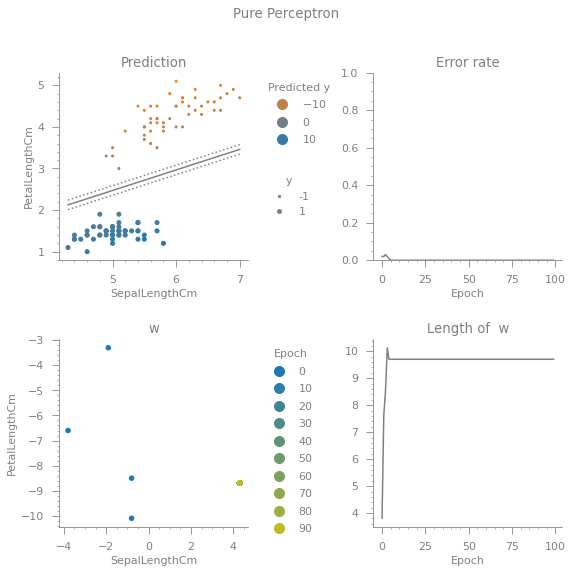

In [6]:
perceptron_obj = perceptron(X, y)     
svm_plot(perceptron_obj, 'SepalLengthCm', 'PetalLengthCm', 'Pure Perceptron')

In [7]:
perceptron_obj

{'w': array([[ -1.9,  -3.3],
        [ -3.8,  -6.6],
        [ -0.8,  -8.5],
        [ -0.8, -10.1],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  4.3,  -8.7],
        [  

As can be seen from the plot above, the "Perceptron" algorithm correctly classifies each point after 5 iterations. It is important to mention that this algorithm does not identify the hyperplane that separates the 2 categories in the 'best' way (for example defining the widest street as possible between them) since there is no mathematical constraint in the algorithm tests that provides any additional improvement after all of the points have been correctly classified. 

In this example, it is purely by chance that the hyperplane resembles very closely the one obtained by the more advanced SVM implementation.

# Simplest SVM

The first improvement to the step above that we are going to introduce is a simple trick that exploit the fact that we changed the categories labels from names to '-1' and '1'.
With this trick we can now use a single test if we multiply the dot-products by the category (y).

The second change we introduce is that the 'learning' (gradient descent) is done in progressively small steps (that's the meaning of '1/epoch'). Do not mind the -2 constant because that is simply the result of the differential equation that forces the street between the support vectors to be the largest.
                                                                                                               
The third change involves the testing, here we test if the result of the dot-product is >=/<= 1 instead of 0 as before. This is the origin of the constranints inposed to the street separating the support-vectors. If it was a different nmber for the 2 conditions, it would imply that the '0' equation is not at the center of the 2 support vectors.
Also, this implies that the 2 (or more) points (1 or more per category) closest to the '0' equation are the support vectors.

In summary, the major improvement up to this point is that we identified a vector 'w' whose dotproduct defines a hyperplane that separates the 2 categories with the widest 'street' in between.

In [33]:
def svm(X, y, epoch_size = 1e4, alpha = 1e-4, **kwargs):
    w_ = np.zeros(X.shape[1])
    epoch_size = int(epoch_size)
    errors = np.zeros(epoch_size) 
    w = np.zeros((epoch_size, X.shape[1]))
    for epoch in range(1, epoch_size + 1):
        for i in range(X.shape[0]):
            y_dot = y[i] * np.dot(X[i, :], w_)
            if y_dot >= 1:
                w_ = w_ + alpha *  (-2/epoch * w_)  #  w_new = w - 2 *eta * w, --> w*(-2 eta)
            else:
                w_ = w_ + alpha * ((-2/epoch * w_) + (X[i, :] * y[i]))  # w_new = w - 2 *eta * (w + x)
                errors[epoch-1] += 1
        w[epoch-1, :] = w_
    y_predicted = np.matmul(X, w_)
    errors = errors / X.shape[0]
    w_length = np.apply_along_axis(np.linalg.norm, 1, w)
    obj = dict(w = w, errors = errors, X = X, y = y, y_predicted = y_predicted, w_length = w_length)
    return obj

Note:

w_ = w_ + alpha * ((-2/epoch * w_) + (X[i, :] * y[i]))

This line is the actual gradient descent. 
Although the derivate in this case looks slightly different compared to the one described in the dedicated section above (in that case the cost function was the sum of squares), there are striking similarities between the 2.
For example, the weight vector is updated by itself plus a term depending on the input vector myltiplied by the 'delta'. In this case, the 'delta' is y[i] since 0-y[i] is just y[i] (note that the signs are swapped).

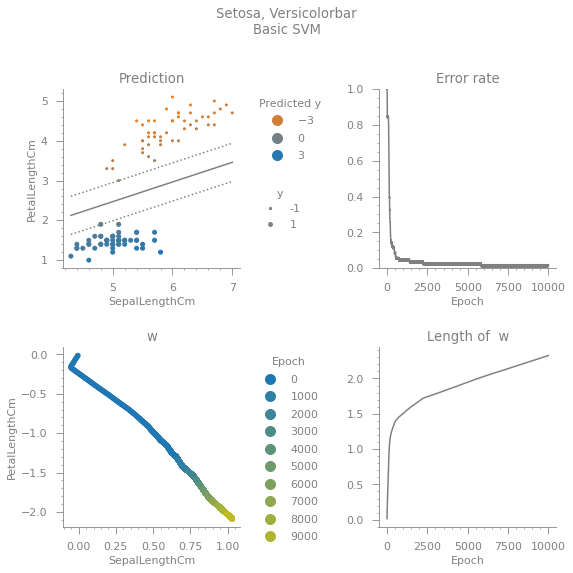

In [39]:
svm_obj = svm(X, y)     
svm_plot(svm_obj, 'SepalLengthCm', 'PetalLengthCm', 'Setosa, Versicolorbar\nBasic SVM')

The effect of the progressively smaller size of the steps (1/epoch) is that most of the improvement is done on the first ~1000 iterations (2nd plot). On the 3rd plot it is possible to see that most of the change in 'w' is achieved during the first ~1000 iterations)

In [40]:
svm_obj

{'w': array([[-0.00487334, -0.01398281],
        [-0.00958711, -0.02782519],
        [-0.01424837, -0.04162135],
        ...,
        [ 1.0301123 , -2.08470839],
        [ 1.03008024, -2.08481422],
        [ 1.03004817, -2.08492005]]),
 'errors': array([1.  , 1.  , 1.  , ..., 0.02, 0.02, 0.02]),
 'X': array([[5.1, 1.4],
        [4.9, 1.4],
        [4.7, 1.3],
        [4.6, 1.5],
        [5. , 1.4],
        [5.4, 1.7],
        [4.6, 1.4],
        [5. , 1.5],
        [4.4, 1.4],
        [4.9, 1.5],
        [5.4, 1.5],
        [4.8, 1.6],
        [4.8, 1.4],
        [4.3, 1.1],
        [5.8, 1.2],
        [5.7, 1.5],
        [5.4, 1.3],
        [5.1, 1.4],
        [5.7, 1.7],
        [5.1, 1.5],
        [5.4, 1.7],
        [5.1, 1.5],
        [4.6, 1. ],
        [5.1, 1.7],
        [4.8, 1.9],
        [5. , 1.6],
        [5. , 1.6],
        [5.2, 1.5],
        [5.2, 1.4],
        [4.7, 1.6],
        [4.8, 1.6],
        [5.4, 1.5],
        [5.2, 1.5],
        [5.5, 1.4],
        [4.9, 1.5]

Support vectors are constrained to be +1 and -1, so, they are the closest to 1.

To be noted is that the support vectors are not exactly +/-1, although they are very close to these values. This has to do with the optimization process and the fact that the weight vector approaches numerically the point of minima with some aproximation given by the step size.

Support vectors predicted y: [ 0.98288314 -1.00151446]


Text(0, 0.5, 'PetalLengthCm')

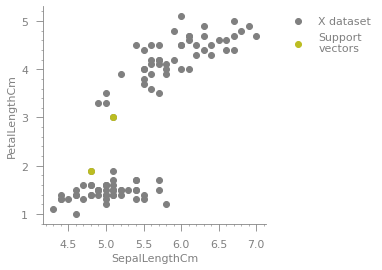

In [45]:
sv = np.argsort(np.abs(svm_obj['y_predicted']) - 1)[0:2]
print(f'Support vectors predicted y: {svm_obj["y_predicted"][sv]}')

fig, ax = plt.subplots(1,1, figsize = (4,4))
ax.scatter(X[:, 0], X[:, 1], c = 'grey', label = 'X dataset')
ax.scatter(X[sv, 0], X[sv, 1], c = 'tab:olive', label = 'Support\nvectors')
ax.legend(bbox_to_anchor = (1.05, 1))
ax.set_xlabel('SepalLengthCm', color = 'grey')
ax.set_ylabel('PetalLengthCm', color = 'grey')

# SVM with additional 'b' (bias) constant

In [13]:
def svm_2(X, y, epoch_size = 1e4, alpha = 1e-4, **kwargs):
    b = (kwargs['b'] if 'b' in kwargs else 0) 
    w_ = np.zeros(X.shape[1])
    epoch_size = int(epoch_size)
    errors = np.zeros(epoch_size) 
    w = np.zeros((epoch_size, X.shape[1]))
    for epoch in range(1, epoch_size + 1):
        for i in range(X.shape[0]):
            y_dot = y[i] * (np.dot(X[i, :], w_) + b)
            if y_dot >= 1:
                w_ = w_ + alpha *  (-2/epoch * w_) 
            else:
                w_ = w_ + alpha * ((-2/epoch * w_) + (X[i, :] * y[i]))
                errors[epoch-1] += 1
        w[epoch-1, :] = w_
    y_predicted = np.matmul(X, w_) + b
    errors = errors / X.shape[0]
    w_length = np.apply_along_axis(np.linalg.norm, 1, w)
    obj = dict(w = w, errors = errors, X = X, y = y, y_predicted = y_predicted, w_length = w_length, **kwargs)
    return obj

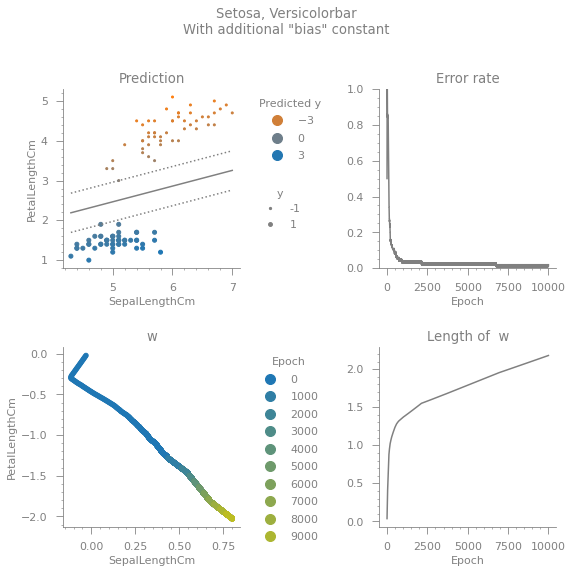

In [14]:
svm_obj_b_coef = svm_2(X, y, b = 1)     
svm_plot(svm_obj_b_coef, 'SepalLengthCm', 'PetalLengthCm', 'Setosa, Versicolorbar\nWith additional "bias" constant')

# SVM with soft margin

In [15]:
def svm_3(X, y, epoch_size = 1e4, alpha = 1e-4, **kwargs): # Add the 'c' term (the soft margim term)
    b = (kwargs['b'] if 'b' in kwargs else 0) 
    c = (kwargs['c'] if 'c' in kwargs else 0) 
    w_ = np.zeros(X.shape[1])
    epoch_size = int(epoch_size)
    errors = np.zeros(epoch_size) 
    w = np.zeros((epoch_size, X.shape[1]))
    for epoch in range(1, epoch_size + 1):
        y_dots = y * (np.matmul(X, w_) + b)
        e = np.minimum(1, c / np.sum(y_dots < 1)) 
        for i in range(X.shape[0]):
            y_dot = y[i] * (np.dot(X[i, :], w_) + b)
            if y_dot >= 1 - e:# define the new threshold (define the soft margin)
                w_ = w_ + alpha *  (-2/epoch * w_)  
            else:
                w_ = w_ + alpha * ((-2/epoch * w_) + (X[i, :] * y[i]))  # w_new = w - 2 *eta * (w + x)
                errors[epoch-1] += 1
            w[epoch-1, :] = w_
    y_predicted = np.matmul(X, w_) + b
    errors = errors / X.shape[0]
    w_length = np.apply_along_axis(np.linalg.norm, 1, w)
    obj = dict(w = w, errors = errors, X = X, y = y, y_predicted = y_predicted, w_length = w_length, **kwargs)
    return obj

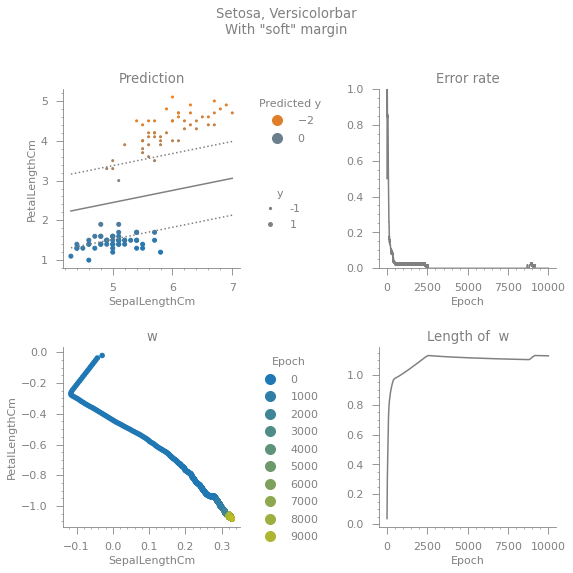

In [16]:
svm_obj_b_coef_c = svm_3(X, y, b = 1, c = 10)     
svm_plot(svm_obj_b_coef_c, 'SepalLengthCm', 'PetalLengthCm', 'Setosa, Versicolorbar\nWith "soft" margin')

In [17]:
svm_obj_b_coef_c

{'w': array([[-0.02953306, -0.0211947 ],
        [-0.04276912, -0.03753   ],
        [-0.0472099 , -0.05126166],
        ...,
        [ 0.32859036, -1.07954102],
        [ 0.32858971, -1.07953887],
        [ 0.32858905, -1.07953671]]),
 'errors': array([0.5 , 0.82, 1.  , ..., 0.  , 0.  , 0.  ]),
 'X': array([[5.1, 1.4],
        [4.9, 1.4],
        [4.7, 1.3],
        [4.6, 1.5],
        [5. , 1.4],
        [5.4, 1.7],
        [4.6, 1.4],
        [5. , 1.5],
        [4.4, 1.4],
        [4.9, 1.5],
        [5.4, 1.5],
        [4.8, 1.6],
        [4.8, 1.4],
        [4.3, 1.1],
        [5.8, 1.2],
        [5.7, 1.5],
        [5.4, 1.3],
        [5.1, 1.4],
        [5.7, 1.7],
        [5.1, 1.5],
        [5.4, 1.7],
        [5.1, 1.5],
        [4.6, 1. ],
        [5.1, 1.7],
        [4.8, 1.9],
        [5. , 1.6],
        [5. , 1.6],
        [5.2, 1.5],
        [5.2, 1.4],
        [4.7, 1.6],
        [4.8, 1.6],
        [5.4, 1.5],
        [5.2, 1.5],
        [5.5, 1.4],
        [4.9, 1.5]

What we did in this step was simply to modify the threshold of the testing to 0 <= value <= 1. In this way the definition of the hyperplane is relaxed by having a lower threshold. 

There are different ways to implement this step, in this case this was done by simply reducing threshold by c / (sum of misclassifications on iteration) if the sum of misclassification is greater than c.

# Iris-virginica vs Iris-versicolor

The example below runs the same 3 functions as above but on the 2 groups of iris that are not separable by a line. This is a much more realistic example compared to the one above and shows the importance of the soft margins.

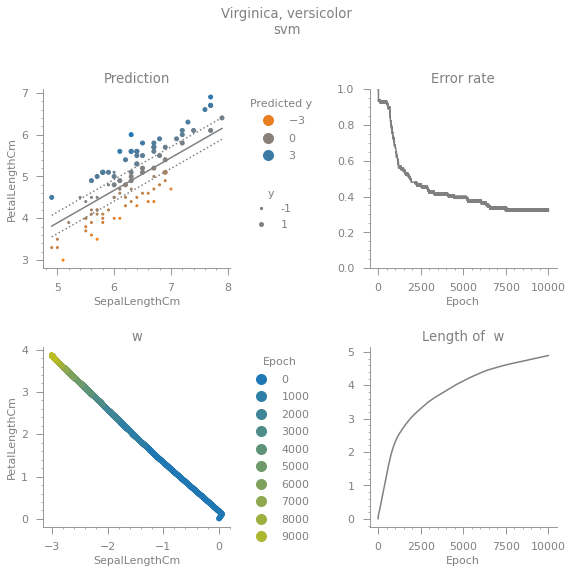

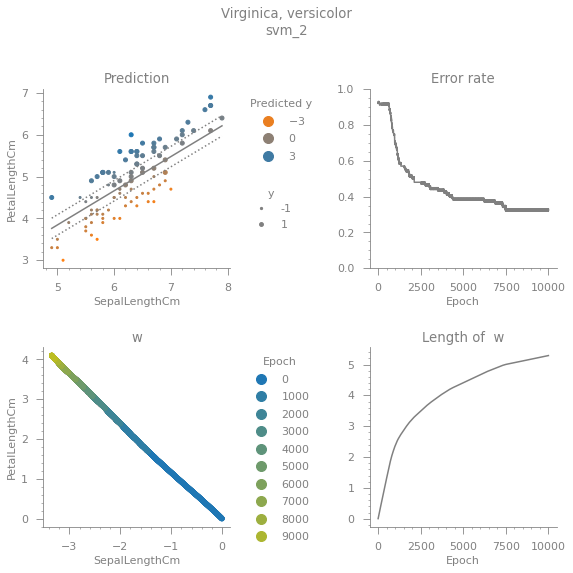

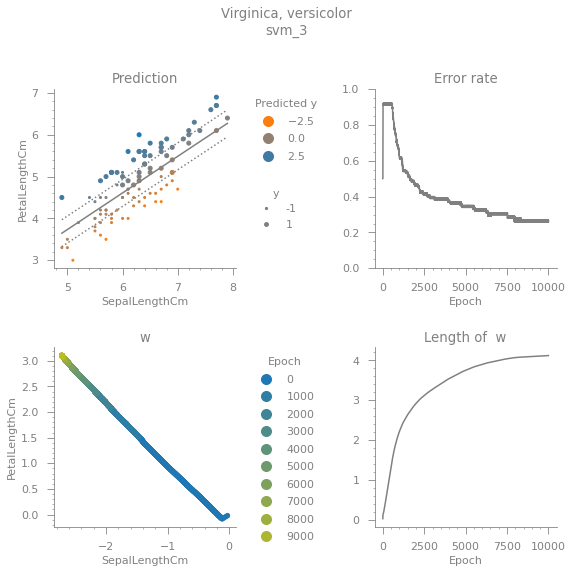

In [18]:
fraction_train = 0.8
iris_model = iris.query('Species == "Iris-virginica" | Species == "Iris-versicolor"')
iris_model = iris_model.replace({'Species':{'Iris-virginica':1, 'Iris-versicolor':-1}})

X2 = iris_model.loc[:, ['SepalLengthCm',  'PetalLengthCm']].values
y2 = iris_model.loc[:, 'Species'].values

functions = [svm, svm_2, svm_3]
dict_args = [{'b':1}, {'b':1}, {'b':2, 'c':20}]
svm_virginica_versicolor = list(map(lambda fun, args: fun(X2, y2, **args), functions, dict_args))

for x, fun in zip(svm_virginica_versicolor, functions):
    svm_plot(x, 'SepalLengthCm', 'PetalLengthCm', 'Virginica, versicolor\n' + fun.__name__)

# Non-linear SVM

Conversely to the situations in the examples above where the 2 groups can be separated linearly, often this is not possible. One classic example is the one illustrated below where there is no straight line able to separate the 2 groups (one of which located inside the other).

Text(0, 0.5, 'x2')

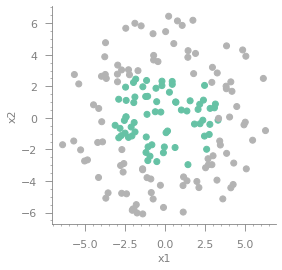

In [19]:
mu_x1_x2 = [0, 0]
sd_x1_x2 = [5, 5]
dataset_test = pd.DataFrame({
     'x1':np.random.normal(mu_x1_x2[0], sd_x1_x2[0], 300), 
     'x2':np.random.normal(mu_x1_x2[1], sd_x1_x2[1], 300)
     })

dist_from_mu = np.linalg.norm(dataset_test - np.array(mu_x1_x2)[np.newaxis, :], axis = 1)
dataset_test['category'] = np.select([dist_from_mu < np.std(dist_from_mu)], [ [-1]*dataset_test.shape[0] ], default = 1) # assign the closest to the center to category '-1'
dataset_test = dataset_test.loc[dist_from_mu < 2 * np.std(dist_from_mu), :] # remove outlayer points
del dist_from_mu

_, ax = plt.subplots(1,1, figsize = (4, 4))
ax.scatter(
    x = dataset_test.x1, 
    y = dataset_test.x2, 
    c = dataset_test.category, 
    cmap = 'Set2'
    )
ax.set_xlabel('x1', color = 'grey')
ax.set_ylabel('x2', color = 'grey')

What mentioned above however, does not imply that the 2 groups cannot be separated. In situations such as those there always is a function that can 'deform' the space and make the groups separable; and the good part is that it does not need to have the same number of dimensions. In this example we transform the dataset from R2 to R3: (x1, x2) --> (x1$^2$, x2$^2$, $\sqrt{2}*x1*x2$).

Text(0.5, 0, '$\\sqrt{2}$ x1 x2')

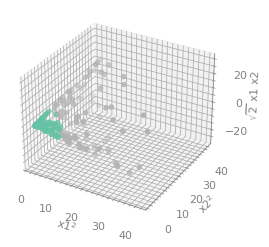

In [20]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize = (4,4))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    xs = dataset_test.x1 **2, 
    ys = dataset_test.x2 **2, 
    zs= np.sqrt(2) * dataset_test.x1 * dataset_test.x2,  
    c = np.power((dataset_test.category + 3), 2), 
    cmap = 'Set2'
    )
ax.set_xlabel('x1$^2$', color = 'grey')
ax.set_ylabel(r'x2$^2$', color = 'grey')
ax.set_zlabel(r'$\sqrt{2}$ x1 x2' , color = 'grey')

In this R3 space there exists a hyperplane (with the shape of an actual plane instead of a line like in the previous examples) that separates the 2 categories. 


What is so special from this transformation? In other words, in this particular example, taking just the square of the 2 dimensions would have been enough to define a hyperplane capable of separating the 2 groups.

Text(0, 0.5, 'x2$^2$')

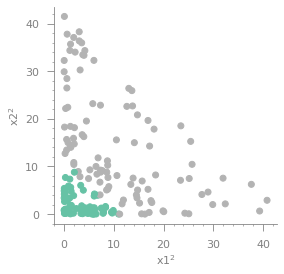

In [21]:
_, ax = plt.subplots(1,1, figsize = (4, 4))
ax.scatter(
    x = dataset_test.x1 ** 2, 
    y = dataset_test.x2 ** 2, 
    c = dataset_test.category, 
    cmap = 'Set2'
    )
ax.set_xlabel('x1$^2$', color = 'grey')
ax.set_ylabel('x2$^2$', color = 'grey')

The answer lies in expanding the dotproduct between the transformed point and the transformed 'w':

let's define the transformation of a vector $\vec x$ as $\phi(\vec x) = (x1^2, x2^2, \sqrt{2}*x1*x2$)

Then: 

$\phi(\vec x) \cdot \phi(\vec w) = (x1^2, x2^2, \sqrt{2} x1 x2) \cdot (w1^2, w2^2, \sqrt{2} w1 w2$) 

$\phi(\vec x) \cdot \phi(\vec w) = x1^2w1^2 + x2^2w2^2 + 2 x1 w1 x2 w2 $

$\phi(\vec x) \cdot \phi(\vec w) = (x1w1 + x2w2)^2 = (\phi(\vec x) \cdot \phi(\vec w))^2$
    
Therefore, the transformation $\phi(\vec x) = (x1^2, x2^2, \sqrt{2}*x1*x2$) when dotted with another vector is simply the suared of the dot-product. In the case of SVM, we donot need to apply the same transformation to 'w' since it is itself the vector we are after.

In [22]:
X_dataset_test = dataset_test.loc[:, ['x1', 'x2']].values
y_dataset_test = dataset_test.loc[:, 'category'].values

def svm_4(X, y, epoch_size = 1e4, alpha = 1e-4, **kwargs):
    b = (kwargs['b'] if 'b' in kwargs else 0) 
    c = (kwargs['c'] if 'c' in kwargs else 0) 
    if 'function' in kwargs:
        X = np.apply_along_axis(eval(kwargs['function']), axis = 1, arr = X) # Kernel trick
    w_ = np.zeros(X.shape[1])
    epoch_size = int(epoch_size)
    errors = np.zeros(epoch_size)
    w = np.zeros((epoch_size, X.shape[1]))
    for epoch in range(1, epoch_size + 1):
        y_dots = y * (np.matmul(X, w_) + b)
        e = np.minimum(1, c / np.sum(y_dots < 1)) 
        for i in range(X.shape[0]):
            y_dot = y[i] * (np.dot(X[i, :], w_) + b)
            if y_dot >= 1 - e:
                w_ = w_ + alpha *  (-2/epoch * w_)  
            else:
                w_ = w_ + alpha * ((-2/epoch * w_) + (X[i, :] * y[i])) 
                errors[epoch-1] += 1
        w[epoch-1, :] = w_
    y_predicted = np.matmul(X, w_) + b
    errors = errors / X.shape[0]
    w_length = np.apply_along_axis(np.linalg.norm, 1, w)
    obj = dict(w = w, errors = errors, X = X, y = y, y_predicted = y_predicted, w_length = w_length, **kwargs)
    return obj

In [23]:
non_linear_svm = svm_4(
    X_dataset_test, 
    y_dataset_test, 
    alpha = 1e-2,
    epoch_size = 1e3,
    function = 'lambda x: np.array([ x[0]**2, x[1]**2, np.sqrt(2) * x[0] * x[1] ])',
    b = -5,
    c = 10
    )

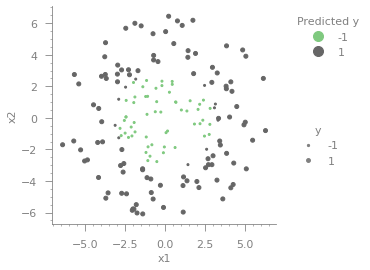

In [24]:
_, ax = plt.subplots(1,1, figsize = (4, 4))

pl1 = ax.scatter(
    x = dataset_test.x1, 
    y = dataset_test.x2, 
    s = np.power((dataset_test.category + 3), 2), 
    c = np.sign(non_linear_svm['y_predicted']),
    cmap = 'Accent'
    )

ax.set_xlabel('x1', color = 'grey')
ax.set_ylabel('x2', color = 'grey')

legend1 = ax.legend(
    pl1.legend_elements(prop='colors', num = 3, size = 10)[0][0:3:2], [-1, 1], 
    bbox_to_anchor = (1.05, 1), 
    title = 'Predicted y'
)
ax.add_artist(legend1)
ax.legend(
    pl1.legend_elements(prop='sizes', num = 3, color = 'grey')[0][0:3:2], 
    [-1, 1], 
    bbox_to_anchor = (1.05, 0.5), 
    title = 'y'
)

# Models assessment

In [63]:
fraction_train = 0.8
iris_model = iris.query('Species == "Iris-virginica" | Species == "Iris-versicolor"')
iris_model = iris_model.replace({'Species':{'Iris-virginica':1, 'Iris-versicolor':-1}})

np.random.seed(6)
idx = np.random.choice(
    iris_model.index.values, 
    replace = False, 
    size = np.int8(np.floor(iris_model.shape[0] * fraction_train))
    )
idx = np.sort(idx)

X_train = iris_model.loc[idx, ['SepalLengthCm',  'PetalLengthCm']].values
y_train = iris_model.loc[idx, 'Species'].values
X_test = iris_model.loc[np.invert(iris_model.index.isin(idx)), ['SepalLengthCm',  'PetalLengthCm']].values 
y_test = iris_model.loc[np.invert(iris_model.index.isin(idx)), 'Species'].values 

In [26]:
functions = [svm, svm_2, svm_3]
dict_args = [{'b':1}, {'b':1}, {'b':2, 'c':10}]
svm_train = list(map(lambda fun, args: fun(X_train, y_train, **args), functions, dict_args))

In [27]:
for func, x in zip(functions, svm_train):
    print(f'Classification train: {func.__name__}:\n {np.sign(x["y_predicted"])}') 

Classification train: svm:
 [-1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1.  1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1. -1.
  1.  1.  1. -1.  1.  1.  1.  1.]
Classification train: svm_2:
 [-1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1.  1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1. -1.  1. -1.
  1.  1.  1. -1.  1.  1.  1.  1.]
Classification train: svm_3:
 [-1. -1. -1.  1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1.  1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1.  1. -1. -1. -1. -1. -1.  1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1. 

In [28]:
svm_train

[{'w': array([[ 3.16875393e-04,  3.35896637e-03],
         [ 5.33167382e-04,  6.62694850e-03],
         [ 7.16293841e-04,  9.86492204e-03],
         ...,
         [-3.01432419e+00,  3.83757226e+00],
         [-3.01444936e+00,  3.83762613e+00],
         [-3.01457453e+00,  3.83767999e+00]]),
  'errors': array([1.   , 1.   , 1.   , ..., 0.325, 0.325, 0.325]),
  'X': array([[7. , 4.7],
         [5.5, 4. ],
         [6.5, 4.6],
         [5.7, 4.5],
         [6.3, 4.7],
         [4.9, 3.3],
         [5.2, 3.9],
         [5.9, 4.2],
         [6. , 4. ],
         [6.1, 4.7],
         [5.6, 3.6],
         [6.7, 4.4],
         [5.6, 4.5],
         [5.8, 4.1],
         [6.2, 4.5],
         [5.6, 3.9],
         [5.9, 4.8],
         [6.1, 4. ],
         [6.3, 4.9],
         [6.1, 4.7],
         [6.4, 4.3],
         [6.7, 5. ],
         [6. , 4.5],
         [5.7, 3.5],
         [5.5, 3.8],
         [5.8, 3.9],
         [5.4, 4.5],
         [6. , 4.5],
         [6.7, 4.7],
         [6.3, 4.4],
      

In [29]:
def misclassification(y_classification, y_test):
    agreement = y_classification * y_test # -1 = disagreement; 1 = agreement
    counts = np.histogram(agreement)[0][0] # from the histogram take the count array and then the -1 category 
    misclassification_rate = counts / y_test.shape[0]
    return misclassification_rate

def misclassification_svm(X_t, w, y_t, b):
    y_classification = np.sign((np.matmul(X_t, w) + b)) # predict the class of the test dataset based on the vector 'w' obtained from the trained model
    return misclassification(y_classification, y_test)

results_misclassification_svm = list(map(
        lambda X_t, w, y_t, b: misclassification_svm(X_t, w, y_t, b),
            [X_test] * 3, 
            list(map(lambda x: x['w'][-1, :], svm_train)), # extract the last 'w'from each model in svm+train
            [y_test] * 3,
            list(map(lambda x: x.get('b', 0), svm_train)), # extract 'b' from each model in svm+train    
            ))

for func, res in zip(functions, results_misclassification_svm):
    print(f'Misclassification fraction, {func.__name__}: {res}') 

Misclassification fraction, svm: 0.15
Misclassification fraction, svm_2: 0.15
Misclassification fraction, svm_3: 0.15


# K nearest neighbour

KNN is a very simple algorithm at its core (the 4 numbered lines of code in the example below):

    1) Compute the subtraction vectors
    2) Calculate the euclidian lengths of each subtraction vector
    3) Assign the corresponding categories to the lowest 'K' lengths
    4) Pick the most represented category

In this case the algorithm is as simple as possible. It is true that the most sofisticated version of KNN (such as the ones implemented in different package distributions) provide in addition to the classifications, also a decision boundary (similarly concept as SVM), but here, there is no model building at all, the algorithm returns just the classification of the test data points.

In [30]:
def knn(X_train, y_train, X_test, K = 5):
    classification = np.zeros(X_test.shape[0])
    for i, point in enumerate(X_test):
        xdiff = np.subtract(X_train, point[np.newaxis, :]) # 1
        dists = np.linalg.norm(xdiff, axis = 1) # 2
        classes, counts = np.unique(y_train[dists.argsort()[0:K]], return_counts=True) # 3
        classification[i] = classes[counts.argmax()] # 4
        # Pandas way of doing it
        # counts = pd.Series(y_train[dists.argsort()[0:K]]).value_counts() # 3
        # classification[i] = counts[counts == counts.max()].index[0] # 4
    return classification

In [31]:
K_set = [3,4,5]
knn_virginica_versicolor = list(map(lambda K: knn(X_train, y_train, X_test, K = K), K_set))

for K, knn_v_v in zip(K_set, knn_virginica_versicolor):
    print(f'K = {K}:\n{knn_v_v}') 

K = 3:
[-1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1. -1.  1.  1.  1.
  1.  1.]
K = 4:
[-1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1. -1.  1. -1. -1.  1.  1.
  1.  1.]
K = 5:
[-1. -1. -1. -1. -1. -1. -1.  1.  1.  1.  1.  1.  1.  1. -1. -1.  1.  1.
  1.  1.]


In [32]:
# Performance testing of the models
results_misclassification_knn = list(map(
        lambda args: misclassification(*args), 
        zip(knn_virginica_versicolor, [y_test] * 3)
        ))

for K, res in zip(K_set, results_misclassification_knn):
    print(f'Misclassification fraction, K = {K}: {res}')

Misclassification fraction, K = 3: 0.1
Misclassification fraction, K = 4: 0.2
Misclassification fraction, K = 5: 0.15


# Final considerations

In this particular example, both SVM and KNN provide comparable results, and, often if the 'best' value of K is identified, also KNN can provide very good classification accuracies.

From a personal point of view, I like the simplicity of KNN and its intrinsic flexibility as there is no need to make any assumption (for example in order to identify the most suited transformation like often the case in SVM.

From a performance standpoint instead, SVM can be slower if the model has to be trained. Once the model is available, the classification of 'n' points takes 'n' dot-products ('n' iterations) which is considerably faster than KNN where the number of iterations is 'n' * 't' where 't' is the the size of the train dataset. On the other hand, training a SVM model can be considerably intensive, growing linearly with the number of epoch chosen.

# Apendix: 
# SVM with Scikit-Learn

In [69]:
import sklearn
import sklearn.model_selection
import sklearn.datasets
from sklearn import svm
import copy 

iris = sklearn.datasets.load_iris()

iris2 = copy.deepcopy(iris)
iris2['data'] = iris['data'][np.ix_(np.isin(iris['target'], [1, 2]), [0, 2])] # Use petal length and sepal length columns of the versicolor and virginica species
iris2['target'] = iris['target'][np.isin(iris['target'], [1, 2])] 

iris

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [70]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    iris2['data'],
    iris2['target'],
    train_size = fraction_train
)

X_train, X_test, y_train, y_test

(array([[6.4, 5.3],
        [5.6, 4.1],
        [6.3, 5.1],
        [6.7, 5.7],
        [5.5, 3.8],
        [6.7, 5.8],
        [6.7, 5.7],
        [5.2, 3.9],
        [6.4, 4.3],
        [6.5, 5.5],
        [6.8, 5.5],
        [6.1, 5.6],
        [6.2, 4.5],
        [6.5, 5.8],
        [7. , 4.7],
        [5.7, 3.5],
        [5.9, 4.8],
        [5.6, 3.6],
        [7.4, 6.1],
        [6.9, 4.9],
        [7.9, 6.4],
        [5.7, 4.1],
        [6.7, 5.2],
        [5.6, 4.5],
        [6.5, 5.1],
        [7.7, 6.7],
        [5.6, 4.9],
        [6.3, 4.9],
        [6.4, 5.3],
        [4.9, 4.5],
        [5.8, 4. ],
        [6. , 4.5],
        [7.7, 6.9],
        [6.7, 4.4],
        [6.6, 4.6],
        [5.5, 4. ],
        [5.7, 4.5],
        [5. , 3.3],
        [7.2, 6.1],
        [5.9, 5.1],
        [5.5, 3.7],
        [5.8, 5.1],
        [6.2, 5.4],
        [6.8, 4.8],
        [6.7, 5. ],
        [6.1, 4.6],
        [6. , 5.1],
        [6.3, 4.4],
        [6. , 4.8],
        [5.1, 3. ],


In [35]:
svm_sklearn = svm.SVC(decision_function_shape='ovo') # In this case we do not need to specify one-vs-one (ovo) since we already selected 2 categories only

svm_sklearn.fit(X_train, y_train)

sklearn_prediction = svm_sklearn.predict(X_test)

In [36]:
svm_svm_3 = svm_3(X_train, np.select([y_train == 1, y_train == 2], [-1, 1]), b = 0) # need to change the labels of the categories in order for the svm_3 to work

svm_3_prediction = np.sign((np.matmul(X_test, svm_svm_3['w'][-1]) + svm_svm_3['b']))

svm_3_prediction = np.select([svm_3_prediction == -1, svm_3_prediction == 1], [1, 2]) # need to put back the original labels

In [37]:
sklearn_prediction, svm_3_prediction, y_test

(array([1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2]),
 array([1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2]),
 array([1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2]))

In [38]:
svm_sklearn.support_vectors_

array([[7. , 4.7],
       [5.9, 4.8],
       [6.9, 4.9],
       [5.6, 4.5],
       [6. , 4.5],
       [6.6, 4.6],
       [5.7, 4.5],
       [6.8, 4.8],
       [6.7, 5. ],
       [6.1, 4.6],
       [6. , 5.1],
       [5.1, 3. ],
       [6.3, 4.9],
       [6.1, 4.7],
       [5.5, 4.4],
       [5.4, 4.5],
       [6. , 4.5],
       [6.3, 5.1],
       [7.9, 6.4],
       [6.7, 5.2],
       [6.5, 5.1],
       [5.6, 4.9],
       [6.3, 4.9],
       [4.9, 4.5],
       [7.7, 6.9],
       [5.9, 5.1],
       [5.8, 5.1],
       [6. , 4.8],
       [6.1, 4.9],
       [6.3, 5. ],
       [5.7, 5. ],
       [6.2, 4.8],
       [6.5, 5.2],
       [6.9, 5.1],
       [6. , 5. ]])

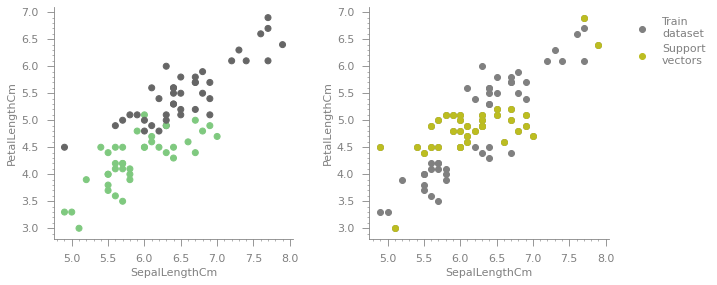

In [39]:
fig, ax = plt.subplots(1,2, figsize = (10,4), constrained_layout = True)
ax[0].scatter(*X_train.T.tolist(), c = y_train, cmap = 'Accent')

ax[1].scatter(*X_train.T.tolist(), c = 'grey', label = 'Train\ndataset')
ax[1].scatter(*svm_sklearn.support_vectors_.T.tolist(), c = 'tab:olive', label = 'Support\nvectors')
ax[1].legend(bbox_to_anchor = (1.05, 1))
for a in ax:
    a.set_xlabel('SepalLengthCm', color = 'grey')
    a.set_ylabel('PetalLengthCm', color = 'grey')

It is quite clear looking at the disposition of the support vectors in the model generated by scikit-learn that this algorithm works differently (quite expected) compared to the one we generated above. In particular, the orientation of the hyperplane separating the 2 classes has a slightly lower slope (even though, the actual dataset in this case was a train subset of the total one). I believe this is likely due to a more sofisticated error function in the version implemented in Scikit-Learn. This algorithm possibly weights more the width of the 'road' encompassing the support vectors than it does in the version implemented here.

# Define a 'svm_tutorial' class with similar structure as in Scikit-Learn

Once the piece-by-piece implementation and testing is done, it is a good practice to wrap the functions in a dedicated class with 'fit' and 'predict' methods. As a rule of thumb spending some work to wrap the workflow in a class will save a lot of efforts and potential mistakes later on (one example of this could be the label swapping done above). 

In [144]:
class svm_tutorial:
    '''
    Arguments: 
        epoch_size (scalar, default = 1e4)
        alpha (scalar, default = 1e-4)
        b (bias term, scalar, default = 0)
        c (misclassification allowed, scalar, default = 0)
        function (string to be called, default = False) 
    '''
    
    def __init__(self, **kwargs):
        self.epoch_size = int(kwargs.get('epoch_size', 1e4))
        self.alpha = kwargs.get('alpha', 1e-4)
        self.b = kwargs.get('b', 0) 
        self.c = kwargs.get('c', 0)
        self.function = kwargs.get('function', False)

    def __repr__(self):
        return f'svm_tutorial(epoch_size = {self.epoch_size}, alpha = {self.alpha}, b = {self.b}, c = {self.c}, function = {self.function})'
        
    def fit(self, X, y):
        '''
        Arguments:
            X,
            y (needs to have just 2 classes)
        '''
        self.labels_original = np.unique(y)
        if len(self.labels_original) != 2:
            raise Exception(f'The "y" categories are: {self.labels_original}. Provide a "y" dataset with just 2 categories/levels')
        if not np.all(self.labels_original == [-1, 1]): # whatever the labels are, hey are swapped to +/-1
            y = np.select([y == self.labels_original[0], y == self.labels_original[1]], [-1, 1])
        if self.function:
            X = np.apply_along_axis(eval(self.function), axis = 1, arr = X)
        w = np.zeros(X.shape[1])
        for epoch in range(1, self.epoch_size + 1):
            y_dots = y * (np.matmul(X, w) + self.b)
            e = np.minimum(1, self.c / np.sum(y_dots < 1)) 
            for i in range(X.shape[0]):
                y_dot = y[i] * (np.dot(X[i, :], w) + self.b)
                if y_dot >= 1 - e:
                    w = w + self.alpha * (-2 / epoch * w)  
                else:
                    w = w + self.alpha * ((-2 / epoch * w) + (X[i, :] * y[i]))
        self.w = w
        
    def predict(self, X, rename_categories = True):
        if self.function:
            X = np.apply_along_axis(eval(self.function), axis = 1, arr = X)
        y = np.sign(np.matmul(X, self.w) + self.b)
        if not np.all(self.labels_original == [-1, 1]) and rename_categories: # put back the labels found in the train dataset
            y = np.select([y == -1, y == 1], [self.labels_original[0], self.labels_original[1]])
        return y

In [145]:
svm_tutorial_obj = svm_tutorial()

In [146]:
svm_tutorial_obj

svm_tutorial(epoch_size = 10000, alpha = 0.0001, b = 0, c = 0, function = False)

In [135]:
svm_tutorial_obj.fit(X_train, y_train)

In [136]:
svm_tutorial_obj.w

array([-2.81324041,  3.59785293])

In [137]:
svm_tutorial_obj.predict(X_test)

array([1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2])

In [138]:
y_test

array([1, 1, 1, 2, 1, 1, 1, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 2])

In [139]:
print(dir(svm_tutorial_obj))

['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'alpha', 'b', 'c', 'epoch_size', 'fit', 'function', 'labels_original', 'predict', 'w']


In [140]:
svm_tutorial_obj.__class__

__main__.svm_tutorial